In [4]:
%display latex

In [14]:
# sage comes with a built-in pip:
# ~/Programs/SageMath/sage --pip install dill

import dill
import pickle
from transmembrane_lib import *


from scipy.integrate import odeint
from sympy.plotting import plot
from sympy import init_printing
import sympy
from sympy.abc import t
from sympy import Array, Sum, Indexed, IndexedBase, Idx
init_printing()
from sympy.abc import t # x is the independent variable
from sympy import Function, dsolve, Eq, Derivative, sin, cos, symbols, exp, pi, diff, Poly
from sympy.physics.units.systems import SI
from sympy.physics.units import length, mass, acceleration, force
from sympy.physics.units import gravitational_constant as G
from sympy.physics.units.systems.si import dimsys_SI
import sympy.physics.units as units
#import pprint as pps
import sympy
import sympy.physics.units.util as util
from dataclasses import dataclass
from sympy.simplify.radsimp import collect
from sympy.assumptions.refine import refine
from sympy import init_printing
from sympy.simplify.powsimp import powsimp
init_printing()
from scipy.integrate import odeint
from sympy.plotting import plot
from sympy import init_printing
import sympy
from sympy.abc import t
from sympy import Array, Sum, Indexed, IndexedBase, Idx
init_printing()
from sympy.abc import t # x is the independent variable
from sympy import Function, dsolve, Eq, Derivative, sin, cos, symbols, exp, pi, diff, Poly

def convexp(name, val):
    return Eq(sympy.S(name), val, evaluate=False)

In [19]:
e_o, e_i, e_m, R, l_o, l_i, l_m, d, a_1, a_2, a_3, b_1, b_2, b_3 = symbols('e_o e_i e_m R l_o l_i l_m d a_1 a_2 a_3 b_1 b_2 b_3')
#     e_o = self.extracellular_permittivity * eps0 # S/m
#     e_i = self.intracellular_permittivity * eps0 #S/m
#     e_m = self.membrane_permittivity * eps0 #S/m
#     R = self.cell_diameter / 2
#     self.R = R

#     l_o = self.extracellular_conductivity*Spm # S/m
#     l_i = self.intracellular_conductivity*Spm #S/m
#     l_m = self.membrane_conductivity*Spm #S/m

#     d = self.membrane_thickness
# epsilon_0

sub1, sub2 = symbols('sub1 sub2')
sub1 = (3 * (R**2) - 3 * d * R + d**2)
sub2 = (3 * d * R - d**2)

a_1 = 3 * d * l_o * ((l_i * (sub1)) + l_m*(sub2)) #eq.9a
a_2 = 3 * d * ((l_i * e_o + l_o * e_i) * sub1 + (l_m * e_o + l_o * e_m) * sub2)
a_3 = 3 * d * e_o * (e_i * (sub1) + e_m * sub2)

b_1 = 2 * R**3 * (l_m +     2*l_o) * (l_m + (1/2) * l_i) + 2 * (R-d)**3 * (l_m - l_o) * (l_i - l_m)

b_2 = 2 * R**3 * (l_i * ((1/2) * e_m + e_o) + l_m * ((1/2)*e_i + 2*e_m + 2*e_o) + l_o * (e_i + 2 * e_m)) + (2 * (R - d)**3\
* (l_i * (e_m - e_o) + l_m * (e_i - 2*e_m + e_o) - l_o * (e_i - e_m))) # is this truly a multiply, or a cross?


b_3 = 2 * R**3 * (e_m + 2*e_o) * (e_m + (1/2) * e_i) + 2 * (R-d)**3 * (e_m - e_o) * (e_i - e_m)


display(convexp("a_1", a_1))
display(convexp("a_2", a_2))
display(convexp("a_3", a_3))


For convenience, let's convert the Kotnik equation to standard DE form, following the guide here: https://lpsa.swarthmore.edu/Representations/SysRepTransformations/TF2SDE.html

originally (mistakenly) used A6c (1998). Switched to eq 8, (multiplied by R, eq 10).
also missed switching the top and bottom: the top goes with the input terms (right) and the bottom with the output.


`H(s)= (R*X(s)) / U(s) = (R a3 s^2 + R a2 s + R a3) / (b3 s^2 + b2 s + b1)`


> "Separate the equation so that the output terms, X(s), are on the
left and the input terms, Fa(s), are on the right.  Make sure there are only positive powers of s."

`(b3 s^2 + b2 s + b1) X(s) = (R a3 s^2 + R a2 s + R a3) U(s)`

> "Now take the inverse Laplace Transform (so multiplications by "s" in the Laplace domain are replaced by derivatives in time)."

`b3 x'' + b2 x' + b1 x = R a3 u'' + R a2 u' + R a3 u`

where u is the input function,

Most solvers like gekko want the equation in first order, so we have to substitute in a new state variable representing the first derivative, converting to a system of DEs.

http://www.math.utah.edu/~gustafso/2250systems-de.pdf
http://www.sharetechnote.com/html/DE_HigherOrderDEtoFirstOrderDE.html
https://math.berkeley.edu/~zworski/128/psol12.pdf

https://math.stackexchange.com/questions/1120984/

(reworked because I found the notation confusing (u2 should be the second derivative!))

```
u0 = u
u1 = u'
u2 = u''

      x0 = x
x0' = x1 = x'
x1' = x2 = x'' =

    b3 x'' + b2 x' + b1 x = R a3 u'' + R a2 u' + R a3 u
    x''  = (R a3 u'' + R a2 u' + R a3 u - b2 x' - b1 x)/b3
    x2  = (R*a3*u2 + R*a2*u1 + R*a3*u0 - b2*x1 - b1*x0)/b3

```

docs: "In all simulation modes (IMODE=1,4,7), the number of equations must equal the number of variables."




In [6]:


Eq(x1_v=diff(x0_v,t))
m.Equation(x2_v==x1_v.dt())
m.Equation(x2_v == ((SU0 / (ST0**2))*alpha_v*u2 + (SU0 / ST0)*beta_v*u1 + gamma_v*SU0*u0 - phi_v*(SX0 / ST0)*x1_v - xi_v*SX0*x0_v)/(SX0 / (ST0**2)))

NameError: name 'x0_v' is not defined

# Yen and Nagurka

In [15]:

t, 𝛂, 𝛃, 𝛄, 𝛙, 𝛏, C1, C2, M, J = symbols("t alpha beta gamma phi xi C1 C2  M J")
p_0, p_1, p_2, p_3, p_4, p_5 = symbols("p_0 p_1 p_2 p_3 p_4 p_5")
a_1, b_1 = symbols("a_1, b_1")
t_f = symbols(("t_f"))
j,m,k = symbols("j m k")

P = Function('P')
p = IndexedBase('p')
P = Sum(p[j]*t**j,(j,0,5))#sympy chokes on all of these


λ = Function('lamda')
a = IndexedBase('a')
b = IndexedBase('b')

λ = Sum(a[m] * cos(2 * m * pi * t / t_f), (m, 1, M)) + Sum(b[m] * sin(2 * m * pi * t / t_f), (m, 1, M))

# sympy.pprint(λ)
# sympy.pprint(diff(λ, t))
# sympy.pprint(diff(λ, t, t))

X = P + λ

In [2]:
X

NameError: name 'X' is not defined

In [ ]:
diff(X , t)

In [ ]:
diff(X , t, t)

# Method of undetermined coefficients


# Pore formation

In [ ]:
v_m,alpha,N0,q,v_ep, N_ic = symbols("v_m,alpha,N0,q,v_ep, N_ic", real=True)
N = Function('N')
# v_m = Function('v_m')

v_m = sympy.simplify(solution.rhs)

k = (v_m/v_ep)**2

LHS = diff(N(t),t)
RHS = alpha * exp(k) * (1.0 - (N(t)/N0)*exp(-q*k))

sympy.pprint(Eq(LHS, RHS))

solution = dsolve(Eq(LHS, RHS), N(t), ics={N(0): N_ic})

# adding W(t_f): W_tf, W(t).diff(t,1).subs(t,t_f): d_W_tf}
# raises ValueError: Couldn't solve for initial conditions

# sympy.pprint(sympy.simplify(solution))


In [ ]:
ic(default_virus(np.array([])).alpha)
ic(default_virus(np.array([])).beta)
ic(default_virus(np.array([])).gamma)
ic(default_virus(np.array([])).xi)


# Incorrect pore current formulation

where $\text{v}_m$ is the normalized version

In [ ]:
w0,F,R,T,r_m,diameter,h,sigma,n,N,k = symbols("w0,F,R,T,r_m,diameter,h,sigma,n,N,k")
v_m = Function('v_m')

#v_m = (V_m(t)) * (F/(R*T))

v_m = v_m(t)

i_ep_term_1 = (pi * (r_m**2) * sigma * v_m * R * T) / (F * h)

i_ep_term_2_divisor_1 = exp(v_m)*((w0*exp(w0-n*v_m) - (n*v_m)) / (w0 - (n*v_m)))
i_ep_term_2_divisor_2 = -((w0*exp(w0+n*v_m) + (n*v_m)) / (w0 + (n*v_m)))
i_ep_term_2 = exp(v_m - 1) / (i_ep_term_2_divisor_1 + i_ep_term_2_divisor_2)

i_ep = i_ep_term_1 * i_ep_term_2
# I = C_m dv/dt
# dv_dt = I/C_m
# permittivity already has the eps0 in it
A = 4*pi*(diameter/2)**2
C_m = k * A / h
I_ep = -(i_ep * N / C_m)

I_ep

In [ ]:
print(I_ep.diff(t))

In [ ]:
print(simplify(simplify((I_ep.diff(t))._sage_())))#.canonicalize_radical()

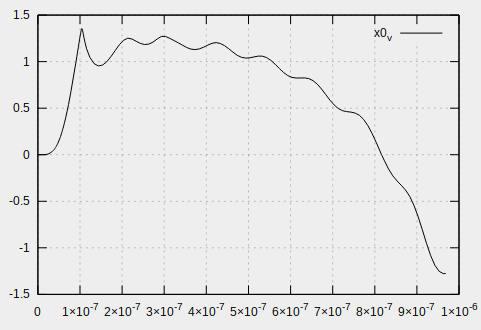



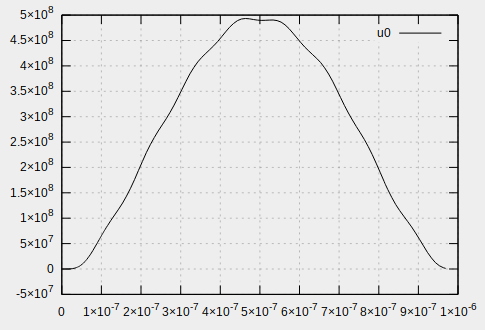

Though the initial "snap" is correctly represented, this is clearly just wrong. 

# Nondimensionalization, attempt 2

- Scale all terms in the virus by the ratio of the diameter?